In [1]:
import sys
import rootpath
sys.path.append(rootpath.detect())

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from testsuite.utilities import Pareto_split

from itertools import combinations as Combinations, product
from numpy.linalg import svd

In [2]:
# def _get_extrusions(pair):
#     if pair.ndim <2:
#         pair = pair.reshape(1, -1)
#     n_points, n_dims = pair.shape
#     return [np.vstack((*c, np.zeros_like(c[0]))) for c in Combinations(pair, n_dims - 1)]

def point_vector_distances(points, vector):
    """
    calculates the distance of all points in points to the nearest
    point in vector
    """
    # argument format checks
    if points.ndim != 2:
        # ensures single point passed is of shape (1, n) rather than (n,)
        points = points.reshape(1, -1)
    assert points.shape[1] == vector.shape[1]

    points_hat = (points.T / np.linalg.norm(points, axis=1)).T
    len_vector = np.linalg.norm(vector)
    vector_hat = vector / len_vector
    cs = vector_hat @ points_hat.T
    return np.sqrt(1 - cs * cs) * len_vector

# def _plane_side_comparison(plane, a, b):
#     """
#     calculates whether points a and b are on the same "side" of plane

#     :param plane: np.ndarray(d-1, d)
#            plane formed of d-1 points, one of which is the origin
#     :param a: np.array(1, d)
#            first point to compare
#     :param b: np.array(1, d)
#            second point to compare

#     :return: bool
#              True if a and b lie on the same side of plane False otherwise.
#     """
#     a = a.reshape(-1)
#     b = b.reshape(-1)

#     e = (plane- plane.mean(axis=0))
#     U, s, vt = svd(e)

#     # check the span of the plane is only d-1
#     np.testing.assert_almost_equal(s[-1], 0)

#     # vector normal to the plane
#     normal_vector = vt[-1]

#     sign_a = np.dot(normal_vector, a.T)>0.
#     sign_b = np.dot(normal_vector, b.T)>0.

#     # check whether they are the same side
#     return sign_a == sign_b

# def _find_intersections(combinations, dmv):
#     # find which combinations in combos are intersected by dmv
#     intersections = np.ones(np.shape(combinations)[0], dtype=bool)
#     for i, comb in enumerate(combinations):
#         midpoint = np.mean(comb, axis=0)

#         # get the cones formed from the origin and combination of points
#         extrusions = _get_extrusions(np.vstack(comb))

#         # find the extrusions for which the mid-point and dmv vector are on
#         # the same side
#         for j, extrusion in enumerate(extrusions):
#             if not _plane_side_comparison(extrusion, dmv, midpoint):
#                 intersections[i] = False
#     return intersections

# def _dm_choice(points, dmv):
#     """
#     chooses set of d points, the surface between which is intersected by
#     the ray dmv, with the smallest sum of squared distances between each
#     point in the set and its nearest point on the vector dmv

#     :param points: np.ndarray (m, d)
#            Array of m d-dimensional points.   
#     :param dmv: np.ndarray(d,)
#            vector representing the decision makers ray of preference

#     :return: np.array(d, d) OR np.array(1, d)
#            chosen set of points which enclose dmv, or single closest point
#            if no set encloses dmv
           
#     """
#     p, d = Pareto_split(points)
    
# #     combinations = np.array([np.vstack((p[-1], c)) for c in Combinations(p, p.shape[1]-1)])
#     combinations = np.array(list(Combinations(p, p.shape[1])))

#     intersections = _find_intersections(combinations, dmv)

#     # choose the combination with the smallest sum of squared disitances to
#     # the DM's preference vector.
#     intersecting_combos = combinations[intersections]
#     try:
#         choice_ind = np.argmin([sum_point_vector_distances(comb, dmv)
#                                 for comb in intersecting_combos])
#         return intersecting_combos[choice_ind]
#     except ValueError:
#         # if no pair is intersected by the dmv return the nearest point
#         return points[np.argmin(point_vector_distances(points, dmv))]

def sum_point_vector_distances(points, vector):
    """
    sum of squared distances between points and vector
    """
    return np.sum(point_vector_distances(points, vector))


In [3]:
np.random.seed(11)
x_2d = abs(np.random.multivariate_normal(np.zeros(2), np.diag(np.ones(2)*5), 150))
x_2d = np.abs((x_2d.T/np.linalg.norm(x_2d, axis=1)).T + np.random.randn(*x_2d.shape)/5)
x_2d.shape

(150, 2)

In [4]:
dmv = np.array([2.5, 1]).reshape(1, -1)
dmv = dmv/np.linalg.norm(dmv)

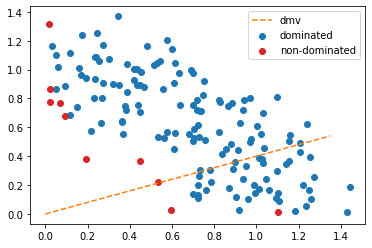

In [5]:
fig = plt.figure()
ax = fig.gca()

p2d, d2d = Pareto_split(x_2d)
ax.scatter(*d2d.T, c="C0", label="dominated")
ax.scatter(*p2d.T, c="C3", label="non-dominated")

magnitude = np.max(np.linalg.norm(x_2d, axis=1))
ax.plot(*np.vstack((np.zeros_like(dmv), dmv*magnitude)).T, c="C1", linestyle="--", label="dmv")
ax.legend()

In [6]:
def _side(V, a):
    a = a.reshape(1, -1) 
    d = a.shape[1]
    
    A = np.vstack((V, np.zeros(d)))
    U, s, Vt = np.linalg.svd(A.T)

    assert s[-1] < 1e-10
    
    n = np.squeeze(U[:,-1])
    
    return bool(np.sign(a@n)>0.)

def build_side_dict_dmv(iterable, dmv):
    n = iterable.shape[1]-1
    if n>1:
        return {key: _side(np.vstack((np.zeros(iterable.shape[1]), [iterable[i] for i in key])), dmv) for key in Combinations(range(len(iterable)), n)}
    else:
        return {key[0]: _side(np.vstack((np.zeros(iterable.shape[1]), [iterable[i] for i in key])), dmv) for key in Combinations(range(len(iterable)), n)}
        
        
def build_side_dict_pairs(iterable):
    n = iterable.shape[1]
    if n>2:
        return {(key[:-1], key[-1]): _side(np.vstack((np.zeros_like(iterable[0]), [iterable[i] for i in key[:-1]])), iterable[key[-1]]) for key in product(*[range(len(iterable))]*n) if len(set(key))==n}
    else:
        return {(key[0], key[-1]): _side(np.vstack((np.zeros_like(iterable[0]), [iterable[i] for i in key[:-1]])), iterable[key[-1]]) for key in product(*[range(len(iterable))]*n) if len(set(key))>1}
        

In [7]:
dmv_side_d = build_side_dict_dmv(d2d, dmv)
dmv_side = build_side_dict_dmv(p2d, dmv)
dmv_side

{0: False,
 1: True,
 2: False,
 3: False,
 4: True,
 5: False,
 6: False,
 7: False,
 8: False,
 9: False}

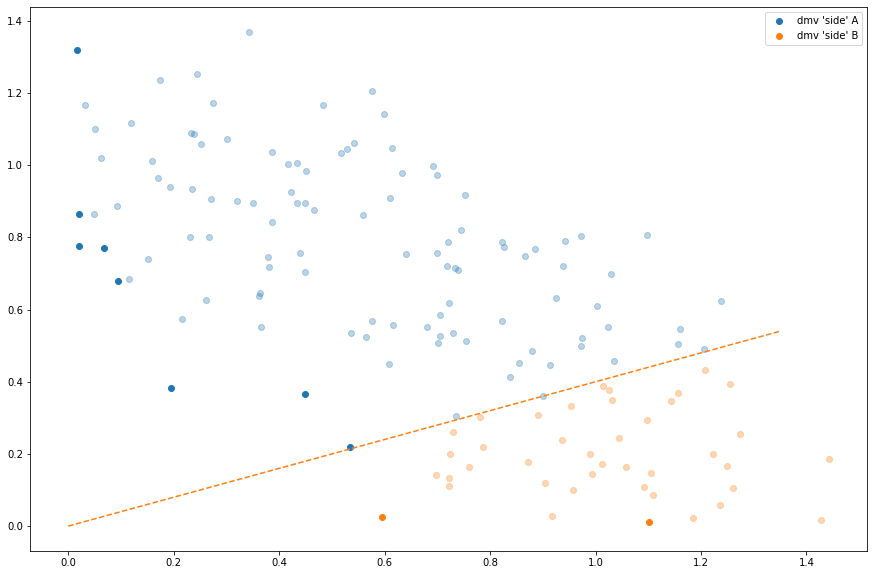

In [8]:
fig = plt.figure(figsize=[15, 10])
ax = fig.gca()

ax.plot(*np.vstack((np.zeros_like(dmv), dmv*magnitude)).T, c="C1", linestyle="--")
for i, b in dmv_side_d.items():
    ax.scatter(*d2d[i].reshape(1, -1).T, c="C{}".format(int(b)), alpha=0.3)
for i, b in dmv_side.items():
    ax.scatter(*p2d[i].reshape(1, -1).T, c="C{}".format(int(b)))
    
    
ax.legend([plt.Line2D([0], [0], c="C0", marker="o", linestyle="None"),
           plt.Line2D([0], [0], c="C1", marker="o", linestyle="None")],
          ["dmv 'side' A","dmv 'side' B"])

In [9]:
pair_side = build_side_dict_pairs(p2d)
pair_side

{(0, 1): False,
 (0, 2): False,
 (0, 3): False,
 (0, 4): False,
 (0, 5): False,
 (0, 6): False,
 (0, 7): False,
 (0, 8): False,
 (0, 9): False,
 (1, 0): True,
 (1, 2): True,
 (1, 3): True,
 (1, 4): False,
 (1, 5): True,
 (1, 6): True,
 (1, 7): True,
 (1, 8): True,
 (1, 9): True,
 (2, 0): True,
 (2, 1): False,
 (2, 3): True,
 (2, 4): False,
 (2, 5): True,
 (2, 6): True,
 (2, 7): False,
 (2, 8): True,
 (2, 9): False,
 (3, 0): True,
 (3, 1): False,
 (3, 2): False,
 (3, 4): False,
 (3, 5): False,
 (3, 6): False,
 (3, 7): False,
 (3, 8): False,
 (3, 9): False,
 (4, 0): True,
 (4, 1): True,
 (4, 2): True,
 (4, 3): True,
 (4, 5): True,
 (4, 6): True,
 (4, 7): True,
 (4, 8): True,
 (4, 9): True,
 (5, 0): True,
 (5, 1): False,
 (5, 2): False,
 (5, 3): True,
 (5, 4): False,
 (5, 6): True,
 (5, 7): False,
 (5, 8): True,
 (5, 9): False,
 (6, 0): True,
 (6, 1): False,
 (6, 2): False,
 (6, 3): True,
 (6, 4): False,
 (6, 5): False,
 (6, 7): False,
 (6, 8): True,
 (6, 9): False,
 (7, 0): True,
 (7, 1)

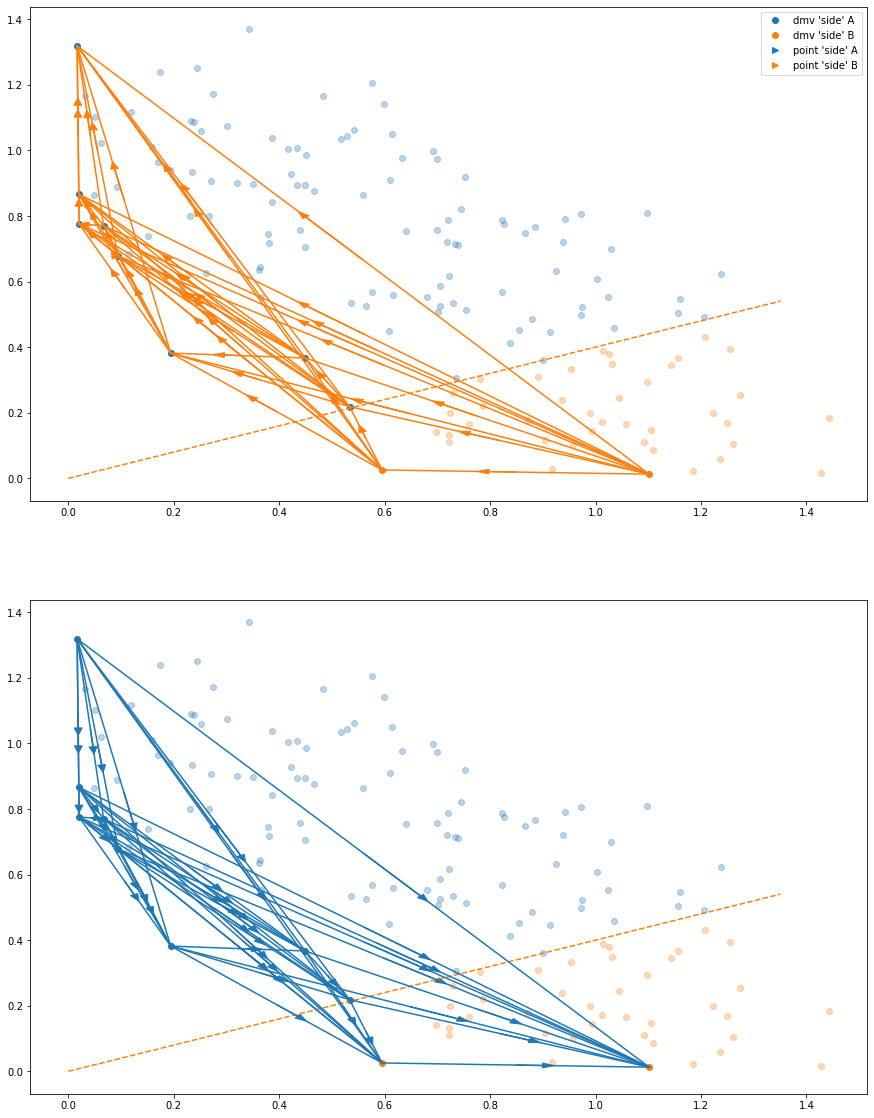

In [10]:
fig = plt.figure(figsize=[15, 20])
ax0 = fig.add_subplot(211)
ax1 = fig.add_subplot(212)

ax0.plot(*np.vstack((np.zeros_like(dmv), dmv*magnitude)).T, c="C1", linestyle="--")
ax1.plot(*np.vstack((np.zeros_like(dmv), dmv*magnitude)).T, c="C1", linestyle="--")
for i, b in dmv_side_d.items():
    ax0.scatter(*d2d[i].reshape(1, -1).T, c="C{}".format(int(b)), alpha=0.3)
    ax1.scatter(*d2d[i].reshape(1, -1).T, c="C{}".format(int(b)), alpha=0.3)
for i, b in dmv_side.items():
    ax0.scatter(*p2d[i].reshape(1, -1).T, c="C{}".format(int(b)))
    ax1.scatter(*p2d[i].reshape(1, -1).T, c="C{}".format(int(b)))
    
    
for (p, t), b in pair_side.items():
    x = p2d[p][0]
    y = p2d[p][1]
    dx = p2d[t][0]-p2d[p][0]
    dy = p2d[t][1]-p2d[p][1]
    if b:
        ax = ax0
    else:
        ax = ax1
    ax.arrow(x+dx/2, y+dy/2, dx/10, dy/10, color="C{}".format(int(b)), head_width=0.015)
    ax.plot(*np.vstack((p2d[p], p2d[t])).T,  c="C{}".format(int(b)))
        
    
ax.legend([plt.Line2D([0], [0], c="C0", marker="o", linestyle="None"),
           plt.Line2D([0], [0], c="C1", marker="o", linestyle="None"),
           plt.Line2D([0], [0], c="C0", marker=">", linestyle="None"),
           plt.Line2D([0], [0], c="C1", marker=">", linestyle="None")],
          ["dmv 'side' A","dmv 'side' B", "point 'side' A", "point 'side' B"])

In [11]:
pairs = list(Combinations(range(len(p2d)), 2))
pairs

pair_inds = [dmv_side[p[0]] == pair_side[p[0], p[1]] and dmv_side[p[1]] == pair_side[p[1], p[0]] for p in pairs]

In [12]:
final_pairs = p2d[np.array(pairs)[pair_inds]]
final_pairs.shape

(16, 2, 2)

In [13]:
def pair_selection(points, dmv):
    n, d = points.shape
    
    dmv_side = build_side_dict_dmv(points, dmv)
    pair_side = build_side_dict_pairs(points)
    
    pairs = list(Combinations(range(n), d))
    pair_inds = [dmv_side[p[0]] == pair_side[p[0], p[1]] and dmv_side[p[1]] == pair_side[p[1], p[0]] for p in pairs]
    
    final_pairs = p2d[np.array(pairs)[pair_inds]]
    ind = np.argmin([sum_point_vector_distances(pair, dmv) for pair in final_pairs])
    return final_pairs[ind]

In [14]:
ans = pair_selection(p2d, dmv)

In [15]:
%%timeit
ans = pair_selection(p2d, dmv)

6.81 ms ± 139 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [16]:
ans = pair_selection(p2d, dmv)

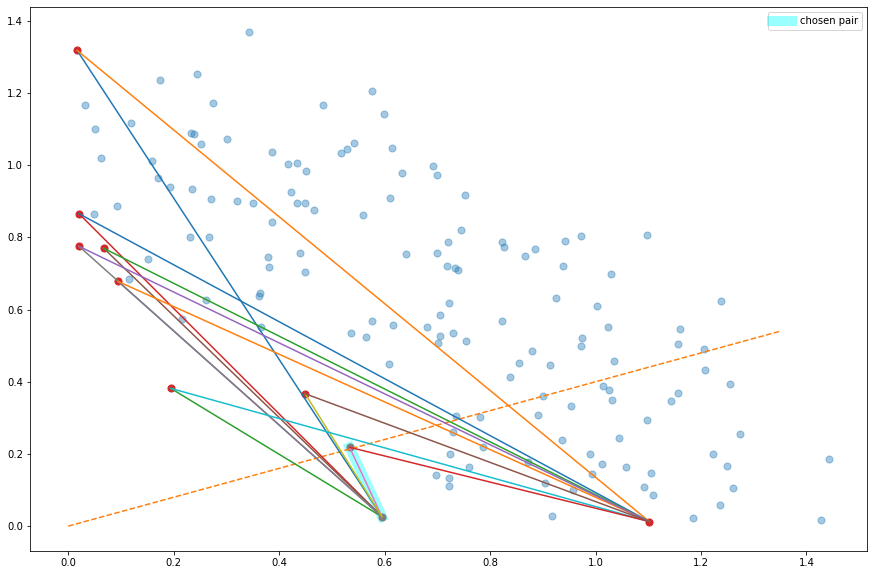

In [17]:
fig = plt.figure(figsize=[15, 10])
ax = fig.gca()


ax.plot(*ans.T, c="cyan", alpha=0.4, linewidth=10, label="chosen pair")
ax.plot(*np.vstack((np.zeros_like(dmv), dmv*magnitude)).T, c="C1", linestyle="--")
ax.scatter(*p2d.T, c="C3", s=50)
ax.scatter(*d2d.T, c="C0", s=50, alpha=0.4)
for pair in final_pairs:
    ax.plot(*pair.T)

ax.legend()
    

### 3D

In [47]:
np.random.seed(3)
x_3d = abs(np.random.multivariate_normal(np.zeros(3), np.diag(np.ones(3)*5), 5))
x_3d = np.abs((x_3d.T/np.linalg.norm(x_3d, axis=1)).T + np.random.randn(*x_3d.shape)/5)
x_3d.shape

(5, 3)

In [48]:
dmv = np.array([2.5, 1.5, 1.5]).reshape(1, -1)
dmv = dmv/np.linalg.norm(dmv)

In [49]:
%matplotlib qt
fig = plt.figure(figsize=[8,8])
ax = fig.gca(projection="3d")

p3d, d3d = Pareto_split(x_3d)
ax.scatter(*d3d.T, c="C0")
ax.scatter(*p3d.T, c="C1")

magnitude = np.max(np.linalg.norm(x_3d, axis=1))
ax.plot(*np.vstack((np.zeros_like(dmv), dmv*magnitude)).T, c="C1", linestyle="--")

In [50]:
dmv_sides = build_side_dict_dmv(p3d, dmv)
dmv_sides

{(0, 1): False,
 (0, 2): True,
 (0, 3): False,
 (0, 4): True,
 (1, 2): True,
 (1, 3): True,
 (1, 4): True,
 (2, 3): True,
 (2, 4): True,
 (3, 4): False}

In [51]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

fig = plt.figure(figsize=[8,8])
ax = fig.gca(projection="3d")

p3d, d3d = Pareto_split(x_3d)
ax.scatter(*d3d.T, c="C0")
ax.scatter(*p3d.T, c="C1")

magnitude = np.max(np.linalg.norm(x_3d, axis=1))
ax.plot(*np.vstack((np.zeros_like(dmv), dmv*magnitude)).T, c="C1", linestyle="--")

for i, (inds, b) in enumerate(dmv_sides.items()):
    if i in [1, 2, 3, 4]:
        P = np.vstack((p3d[list(inds)], np.zeros(3)))
        shape = Poly3DCollection(np.vstack((2*P, np.zeros(3))), alpha=0.2)
        shape.set_facecolor("C{}".format(int(b)))
        ax.add_collection3d(shape)

/home/finley/miniconda3/envs/testsuite/lib/python3.8/site-packages/numpy/lib/function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/finley/miniconda3/envs/testsuite/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [23]:
pair_sides = build_side_dict_pairs(p3d)
pair_sides

{((0, 1), 2): False,
 ((0, 1), 3): False,
 ((0, 1), 4): False,
 ((0, 2), 1): False,
 ((0, 2), 3): True,
 ((0, 2), 4): False,
 ((0, 3), 1): False,
 ((0, 3), 2): False,
 ((0, 3), 4): False,
 ((0, 4), 1): False,
 ((0, 4), 2): True,
 ((0, 4), 3): True,
 ((1, 0), 2): False,
 ((1, 0), 3): False,
 ((1, 0), 4): False,
 ((1, 2), 0): True,
 ((1, 2), 3): True,
 ((1, 2), 4): False,
 ((1, 3), 0): True,
 ((1, 3), 2): False,
 ((1, 3), 4): False,
 ((1, 4), 0): True,
 ((1, 4), 2): True,
 ((1, 4), 3): True,
 ((2, 0), 1): False,
 ((2, 0), 3): True,
 ((2, 0), 4): False,
 ((2, 1), 0): True,
 ((2, 1), 3): True,
 ((2, 1), 4): False,
 ((2, 3), 0): True,
 ((2, 3), 1): True,
 ((2, 3), 4): True,
 ((2, 4), 0): True,
 ((2, 4), 1): True,
 ((2, 4), 3): True,
 ((3, 0), 1): False,
 ((3, 0), 2): False,
 ((3, 0), 4): False,
 ((3, 1), 0): True,
 ((3, 1), 2): False,
 ((3, 1), 4): False,
 ((3, 2), 0): False,
 ((3, 2), 1): False,
 ((3, 2), 4): False,
 ((3, 4), 0): False,
 ((3, 4), 1): False,
 ((3, 4), 2): True,
 ((4, 0), 1)

In [35]:
def pair_selection(points, dmv):
    n, d = points.shape
    
    dmv_side = build_side_dict_dmv(points, dmv)
    print(dmv_side)
    pair_side = build_side_dict_pairs(points)
    
    pairs = list(Combinations(range(n), d))
    pair_inds = [dmv_side[p[0]] == pair_side[p[0], p[1]] and dmv_side[p[1]] == pair_side[p[1], p[0]] for p in pairs]
    
    final_pairs = p2d[np.array(pairs)[pair_inds]]
    ind = np.argmin([sum_point_vector_distances(pair, dmv) for pair in final_pairs])
    return final_pairs[ind]


In [36]:
points = p3d
n, d = points.shape

dmv_side = build_side_dict_dmv(points, dmv)
pair_side = build_side_dict_pairs(points)
list(pair_side.items())[0]

NameError: name 'p3d' is not defined

In [37]:
pairs = list(Combinations(range(n), d))
pairs


NameError: name 'n' is not defined

In [38]:
pair = list(pairs[0])
pair

[0, 1]

In [39]:
inds = []
for pair in pairs:
    sub_pairs = [(p, next(iter((set(pair)-set(p)) )))for p in product(pair, pair) if len(set(p))>1]
    ans = np.all([dmv_side[tuple(sorted(p))] == pair_side[p, s] for p,s in sub_pairs])
    inds.append(ans)

RuntimeError: coroutine raised StopIteration

In [40]:
inds

[]

In [41]:
intersecting = np.array(pairs)[inds]
intersecting

array([], shape=(0, 2), dtype=int64)

In [42]:
chosen = p3d[intersecting]
chosen

NameError: name 'p3d' is not defined

NameError: name 'x_3d' is not defined

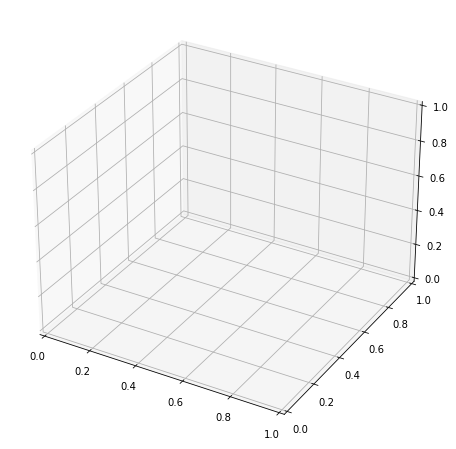

In [43]:
fig = plt.figure(figsize=[8,8])
ax = fig.gca(projection="3d")

p3d, d3d = Pareto_split(x_3d)
ax.scatter(*d3d.T, c="C0")
ax.scatter(*p3d.T, c="C1")

magnitude = np.max(np.linalg.norm(x_3d, axis=1))
ax.plot(*np.vstack((np.zeros_like(dmv), dmv*magnitude)).T, c="C1", linestyle="--")
ax.plot(*np.vstack((chosen[0], chosen[0][0])).T, c="C3", linestyle="--")

In [44]:
chosen.shape

NameError: name 'chosen' is not defined

In [45]:
xs = np.random.multivariate_normal(np.ones(4), np.diag(np.ones(4)), 150)

In [46]:
xs = xs[np.logical_not(np.linalg.norm(xs, axis=1)<2.)]

In [31]:
xs.shape

(123, 4)

In [32]:
p,d  = Pareto_split(xs)

In [33]:
p.shape

(46, 4)

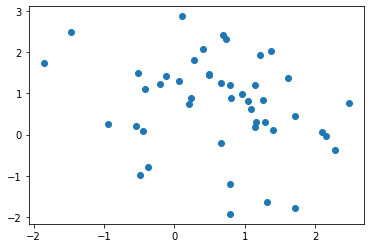

In [34]:
plt.scatter(*p[:, :2].T)